In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm

We got equations: 
$$
\begin{cases}
\frac{dG}{dt} = p_1 G + p_2 X + p_3 \\
\frac{dX}{dt} = p_4 X + I(t)
\end{cases}
$$

Let's first generate G

In [2]:
def getI(t, I_max, a=1, t1=10):
    return I_max / np.cosh(a * (t - t1))

def find_g(p1, p2, p3, p4, p5, X0, I_max, T, step=1):
    '''
    Modelat G with given parameters
    '''
    g = [p5]
    x = [X0]
    
    for t in range(int(T * step)):
        dg_dt = p1 * g[-1] + p2 * x[-1] + p3
        dx_dt = getI(t / step, I_max) + p4 * x[-1]
        
        g.append(g[-1] + dg_dt / step)
        x.append(x[-1] + dx_dt / step)
        
    return np.array(g), np.array(x)

In [12]:
p1 = -6.5 / 100
p2 = -9.1 / 1000
p3 = 5.97
p4 = -1.01 / 10

p5 = 150
X0 = 80
I_max = 100

In [13]:
step = 60
T = 60
G, X = find_g(p1, p2, p3, p4, p5, X0, I_max, T, step)
I = [getI(t / step, I_max) for t in range(int(T * step) + 1)]

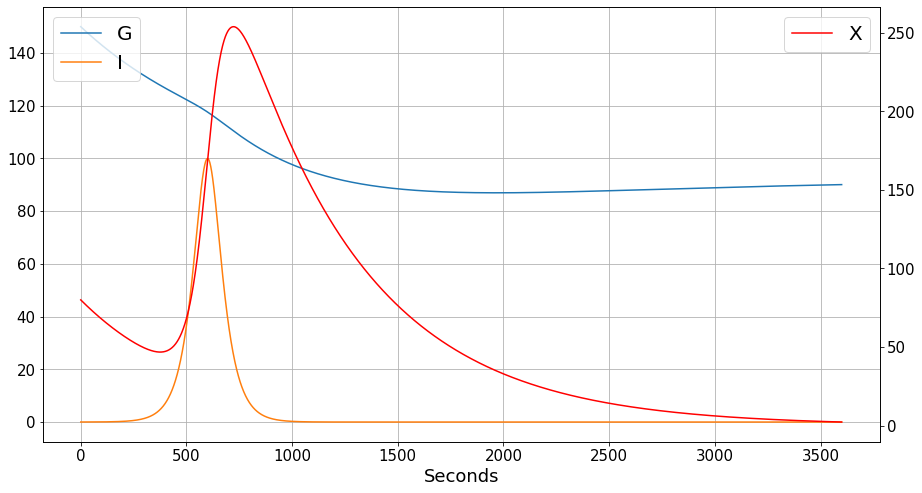

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.rc('ytick',labelsize=15)
plt.rc('xtick',labelsize=15)

plt.plot(G, label='G')
plt.plot(I, label='I')
plt.xlabel('Seconds', fontsize=18)
plt.legend(loc='upper left', prop={'size': 20})
plt.grid()

ax = ax.twinx()
plt.plot(X, label='X', color='r')

plt.legend(prop={'size': 20})

Let's find error of simulation:


In [6]:
errors = []
coefs_ = np.arange(1, 100, 1)
for coef_ in tqdm(coefs_):
    G1, X1 = find_g(p1, p2, p3, p4, p5, X0, I_max, T, step * coef_)
    errors.append((abs((G - G1[::coef_]) / G)).mean() * 100)

100%|██████████| 99/99 [01:11<00:00,  1.39it/s]


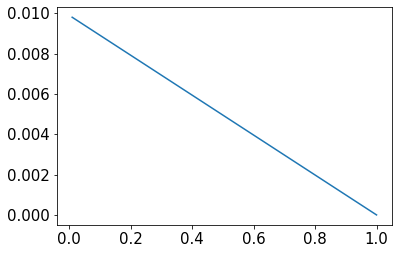

In [7]:
plt.plot(1. / coefs_, errors)

In [8]:
m = LinearRegression().fit((1. / coefs_).reshape(-1, 1), errors)

print("Error:", m.intercept_, "%")

Error: 0.009897860243059149 %


Let's find parameters when we know X and G

p_4

In [22]:
Y = (X[::step][1:] - X[::step][:-1]) * 1 - I[::step][1:]
Z = X[::step][:-1].reshape((-1, 1))

model = LinearRegression(fit_intercept=False).fit(Z[:], Y[:])
y_pred = model.predict(Z[:])
r2_score(y_pred, Y), model.coef_, model.intercept_

(0.3012494205233054, array([-0.08686328]), 0.0)

In [23]:
model.coef_[0] - p4

0.014136718458807582

p_1, p_2, p_3

In [19]:
Y = (G[::step][1:] - G[::step][:-1]) * 1
Z = np.vstack([G[::step][:-1], X[::step][:-1]]).T

model = LinearRegression().fit(Z[:], Y[:])
y_pred = model.predict(Z[:])
r2_score(y_pred, Y), model.coef_, model.intercept_

(0.9978377604189743, array([-0.06402411, -0.00868565]), 5.884889421258146)

In [17]:
print(model.coef_[0] - p1)
print(model.coef_[1] - p2)
print(model.intercept_ - p3)

0.0009758872023378634
0.00041435000286171864
-0.08511057874185379


Let's prove numerically that this problem non-observable. To do so we'll find infinite number parameters for the same G that fit equations

In [27]:
def get_params_basic(p4, G, I, X0, step):
    '''
    For given G, I, p_4 and X(0) find p_1, p_2 and p_3 that fit equations and r2_score of that fit
    '''

    X_ = [X0]

    #find X from second equation
    for pos, g in enumerate(G[:-1]):
        dx_dt = I[pos] + p4 * X_[-1]
        X_.append(X_[-1] + dx_dt / step)

    #find p1, p2, p3 from first equation
    Y = (G[1:] - G[:-1]) * step
    Z = np.vstack([G[:-1], X_[:-1]]).T

    model = LinearRegression().fit(Z[:], Y[:])
    y_pred = model.predict(Z[:])
           
    return r2_score(y_pred, Y), model.coef_, model.intercept_

def get_params_pro(p4, G, I, X0, step):
    '''
    For given p4 and G trying to find X0 (close to one that user defined), so r2_score is best
    Print that r2_score and return p_1, p_2, p_3
    '''
    grid = np.arange(0.5, 2.001, 0.05)
    r2_scores = [get_params_basic(p4, G, I,  X0 * coef, step)[0] for coef in grid]
    best_coef = grid[np.argmax(r2_scores)]
    res = get_params_basic(p4, G, I, X0 * best_coef, step)
    print("R2 score of fit:", round(res[0], 4))
    
    return res[1:], X0 * best_coef

Now for different $p_4$ we'll find different $p_1, p_2, p_3$ that fit equations

In [29]:
res = []
for p4_ in np.arange(0.5, 2, 0.1) * p4:
    print("p_4={}".format(round(p4_, 4)),end=' ')
    ([p1_, p2_], p3_), X0_ = get_params_pro(p4_, G[::step], I[::step], X0, 1)
    res.append([p1_, p2_, p3_, p4_, X0_])
res = np.array(res)

p_4=-0.0505 R2 score of fit: 0.9826
p_4=-0.0606 R2 score of fit: 0.9859
p_4=-0.0707 R2 score of fit: 0.9885
p_4=-0.0808 R2 score of fit: 0.9906
p_4=-0.0909 R2 score of fit: 0.992
p_4=-0.101 R2 score of fit: 0.9928
p_4=-0.1111 R2 score of fit: 0.9931
p_4=-0.1212 R2 score of fit: 0.9929
p_4=-0.1313 R2 score of fit: 0.9924
p_4=-0.1414 R2 score of fit: 0.9915
p_4=-0.1515 R2 score of fit: 0.9903
p_4=-0.1616 R2 score of fit: 0.9889
p_4=-0.1717 R2 score of fit: 0.9873
p_4=-0.1818 R2 score of fit: 0.9856
p_4=-0.1919 R2 score of fit: 0.9837


Here you can see how parameters change

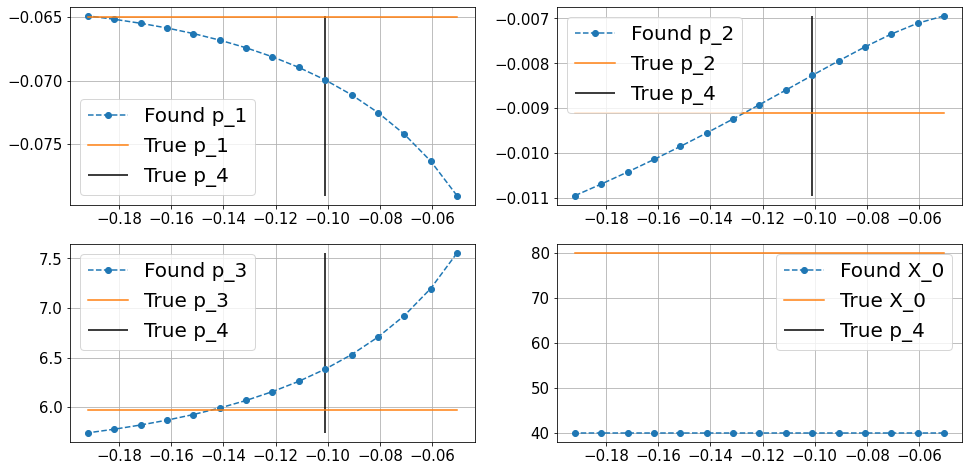

In [30]:
fig = plt.figure(figsize=(16, 8))
# plt.rc('ytick',labelsize=15)
# plt.rc('xtick',labelsize=15)

fig.add_subplot(221)
plt.plot(res[:, 3], res[:, 0], linestyle='--', marker='o', label='Found p_1')
plt.plot(res[:, 3], [p1] * len(res[:, 3]), label='True p_1')
plt.vlines(p4, min(res[:, 0]), max(res[:, 0]), label='True p_4')
plt.grid()
plt.legend(prop={'size': 20})

fig.add_subplot(222)
plt.plot(res[:, 3], res[:, 1], linestyle='--', marker='o', label='Found p_2')
plt.plot(res[:, 3], [p2] * len(res[:, 3]), label='True p_2')
plt.vlines(p4, min(res[:, 1]), max(res[:, 1]), label='True p_4')
plt.grid()
plt.legend(prop={'size': 20})

fig.add_subplot(223)
plt.plot(res[:, 3], res[:, 2], linestyle='--', marker='o', label='Found p_3')
plt.plot(res[:, 3], [p3] * len(res[:, 3]), label='True p_3')
plt.vlines(p4, min(res[:, 2]), max(res[:, 2]), label='True p_4')
plt.grid()
plt.legend(prop={'size': 20})

fig.add_subplot(224)
plt.plot(res[:, 3], res[:, 4], linestyle='--', marker='o', label='Found X_0')
plt.plot(res[:, 3], [X0] * len(res[:, 3]), label='True X_0')
plt.vlines(p4, min(res[:, 4]), max(res[:, 4]), label='True p_4')
plt.grid()
plt.legend(prop={'size': 20})
# plt.legend(loc='lower left', prop={'size': 20})

plt.legend(prop={'size': 20})

Accuracy

In [32]:
errors = []
for params in res:
    G1, X1 = find_g(params[0], params[1], params[2], params[3], p5, params[4], I_max, T, step)
    errors.append((abs((G - G1) / G)).mean() * 100)
max(errors)

1.3346069396006541

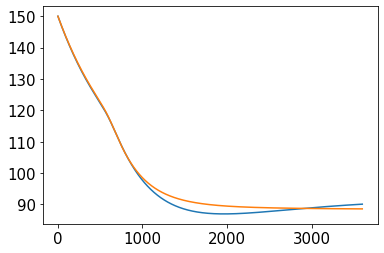

In [33]:
plt.plot(G)
plt.plot(G1)

## So we can see that for one G there could be several $p_1, p_2, p_3, p_4$ that fit equations. So parameters is non-identifiable 

Let's now show that model is observable

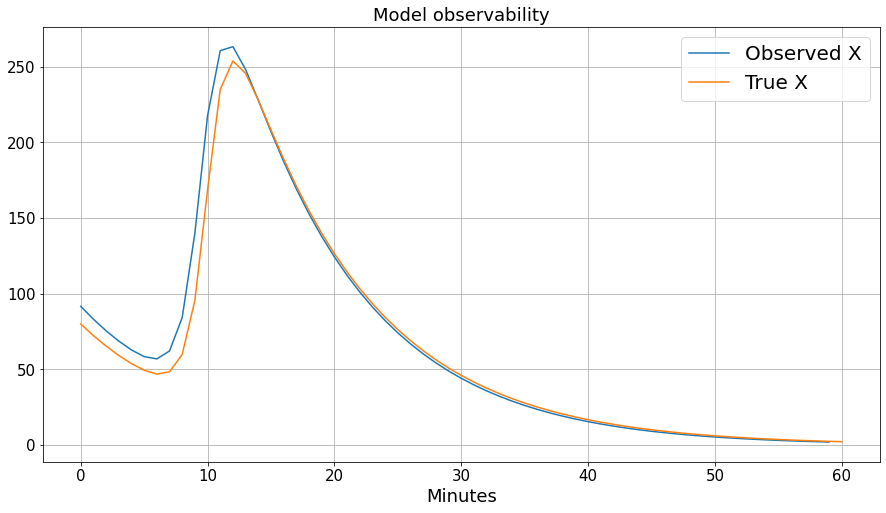

In [41]:
plt.figure(figsize=(15, 8))
plt.rc('ytick',labelsize=15)
plt.rc('xtick',labelsize=15)

plt.plot(((G[::step][1:] - G[::step][:-1]) * 1 - p1 * G[::step][1:] - p3) / p2, label='Observed X')
plt.plot(X[::step], label='True X')
plt.xlabel("Minutes", fontsize=18)
plt.title("Model observability", fontsize=18)
plt.grid()
plt.legend(prop={'size': 20})

In [42]:
mape = ((G[::step][1:] - G[::step][:-1]) * 1 - p1 * G[::step][1:] - p3) / p2 
mape = (abs((mape - X[::step][:-1])/ X[::step][:-1])).mean() * 100
print("MAPE:", mape, '%')

MAPE: 10.358784417055192 %


In [43]:
steps = np.arange(1, 60, 1)
errors = []

for step_ in steps:
    pred = ((G[::step_][1:] - G[::step_][:-1]) * step / step_ - p1 * G[::step_][1:] - p3) / p2 
    err = (abs((pred - X[::step_][:-1]) / X[::step_][:-1])).mean() * 100
    errors.append(err)

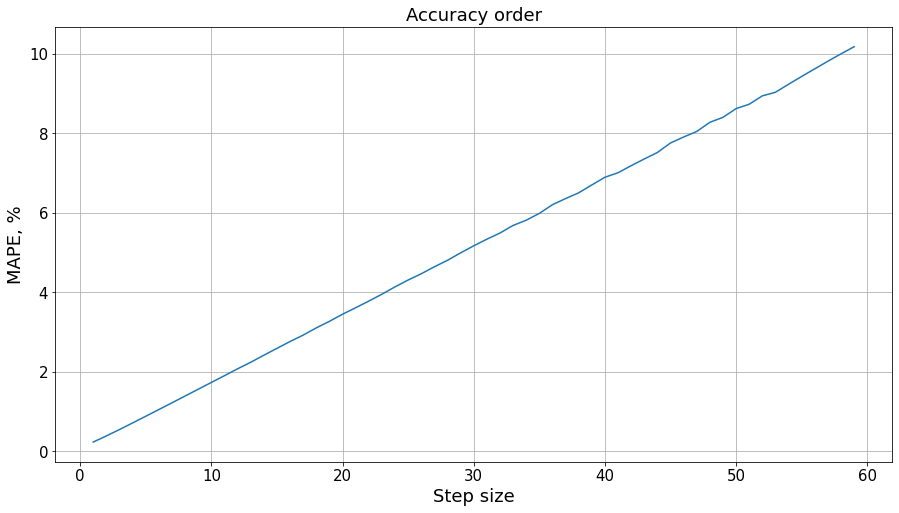

In [45]:
plt.figure(figsize=(15, 8))
plt.rc('ytick',labelsize=15)
plt.rc('xtick',labelsize=15)

plt.xlabel("Step size", fontsize=18)
plt.ylabel("MAPE, %", fontsize=18)
plt.title("Accuracy order", fontsize=18)

plt.grid()
plt.plot(steps, errors)

## So we can see that for one G there could be several $p_1, p_2, p_3, p_4$ that fit equations. So problem is non-observable